<a href="https://colab.research.google.com/github/borgesjose/reconhecimento_de_padroes/blob/master/WEEK%206/anova_atv_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scikit-optimize

In [ ]:
pip install xgboost

# Atividade 6 - Seleção de Features com ANOVA

Atividade (1.25): realizar a seleção de features com a ANOVA atendendo aos seguintes itens:
<ol>
        <li> Modifique a função select_features para receber como parâmetro de entrada o valor de k e altere o código para garantir que todas as features do dataset serão avaliadas; </li> 
        <li> Criar uma função para avaliar os modelos de classificação em termos de acurácia, utilizar o repeated stratified k-fold cross-validation. Você define o número de folds e repetições;</li> 
        <li> Plotar um boxplot da acurácia obtida por cada número de features testados. Um boxplot distinto deve ser plotado para cada classificador. Atenção: utilizar a versão da função get_best_model() que vocês desenvolveram na atividade anterior, contemplando os classificadores svm e gxboost;</li>    
</ol

In [ ]:
from pandas import read_csv
from numpy import nan

In [ ]:
#Fonte: https://www.kaggle.com/uciml/pima-indians-diabetes-database
# data = read_csv('pima-indians-diabetes.csv' , header=None)
data  = read_csv('https://raw.githubusercontent.com/borgesjose/reconhecimento_de_padroes/master/WEEK%206/pima-indians-diabetes.csv')

In [ ]:
x = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [ ]:
def get_best_model(model_name, x, y):
    
    if model_name == 'd_tree':
        params = {'max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
        model = DecisionTreeClassifier()
    elif model_name == 'r_forest':
        params = {'n_estimators': [10, 50, 100, 200], 'max_depth': [None, 1, 3, 5, 7]}
        model = RandomForestClassifier()
    else:
        print("Oops! That was no valid model. Try again...")
    
    
    grid = GridSearchCV(model,           
                        params,          
                        error_score=0.)  
    grid.fit(x, y) 
    
    return grid

### 1. Modifique a função select_features para receber como parâmetro de entrada o valor de k e altere o código para garantir que todas as features do dataset serão avaliadas

In [ ]:
def select_features(K,x_train, y_train, x_test):

    fs = SelectKBest(score_func=f_classif, k=K)
    fs.fit(x_train, y_train)

    x_train_fs = fs.transform(x_train)
    x_test_fs = fs.transform(x_test)

    return x_train_fs, x_test_fs, fs

### 2. Criar uma função para avaliar os modelos de classificação em termos de acurácia, utilizar o repeated stratified k-fold cross-validation. Você define o número de folds e repetições

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score

from sklearn.model_selection import RepeatedStratifiedKFold
import statistics 

In [ ]:
def model_evaluation(n_splits, n_repeats, model_name, x, y, n_feat):

  rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats,random_state=36851234)
  accuracy =[]
  kappa = []
  for train_index, test_index in rskf.split(x, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x.loc[train_index,:], x.loc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

    x_train_fs, x_test_fs, fs = select_features(n_feat, x_train, y_train, x_test)
    
    # Capturar os melhores parâmetros do modelo
    grid = get_best_model(model_name, x_train_fs, y_train)
    
    # Instanciar o modelo com os melhores parâmetros e treiná-lo
    #model = DecisionTreeClassifier(**grid.best_params_)
    
    if model_name == 'd_tree':
        model = DecisionTreeClassifier(**grid.best_params_)
    elif model_name == 'r_forest':
        model = RandomForestClassifier(**grid.best_params_)
    elif model_name == 'svm':
        model = SVC(**grid.best_params_)
    elif model_name == 'gxboost':
        model = model = xgb.XGBClassifier(**grid.best_params_)
    else:
        print("Oops! That was no valid model. Try again...")
    
    model.fit(x_train_fs, y_train)

    # Avaliando o modelo
    yhat = model.predict(x_test_fs)
    acc = accuracy_score(y_test, yhat)
    kapp = cohen_kappa_score(y_test, yhat)
    #print('Accuracy: %.2f ' % (acc*100))
    #print('Kappa: ' + str(kapp)) 
    accuracy.append(acc)
    kappa.append(kapp)

  return accuracy,kappa

In [ ]:
accuracy,kppa = model_evaluation(4,4,'d_tree',x,y,4)

In [ ]:
print('List of possible accuracy:', accuracy)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(accuracy)*100, '%')
print('\nMinimum Accuracy:',
      min(accuracy)*100, '%')
print('\nOverall Accuracy:',
      statistics.mean(accuracy)*100, '%')
print('\nStandard Deviation is:', statistics.stdev(accuracy))

List of possible accuracy: [0.6979166666666666, 0.7447916666666666, 0.6979166666666666, 0.7708333333333334, 0.7447916666666666, 0.6822916666666666, 0.7604166666666666, 0.7447916666666666, 0.7708333333333334, 0.7395833333333334, 0.78125, 0.71875, 0.7395833333333334, 0.78125, 0.6979166666666666, 0.703125]

Maximum Accuracy That can be obtained from this model is: 78.125 %

Minimum Accuracy: 68.22916666666666 %

Overall Accuracy: 73.60026041666666 %

Standard Deviation is: 0.03264916080237803


### 3. Plotar um boxplot da acurácia obtida por cada número de features testados. Um boxplot distinto deve ser plotado para cada classificador. Atenção: utilizar a versão da função get_best_model() que vocês desenvolveram na atividade anterior, contemplando os classificadores svm e gxboost; 

In [ ]:
# Bayes Search Scikit-learn
from skopt import BayesSearchCV
import numpy as np
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pandas as pd
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
import xgboost as xgb


In [ ]:
def get_best_model_2(model_name, opt_name, x, y):
    
    import warnings
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=109) # 70% training and 30% test

    
    if model_name == 'd_tree':
        params = {'max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
        model = DecisionTreeClassifier()
    elif model_name == 'r_forest':
        params = {'n_estimators': [10, 50, 100, 200], 'max_depth': [None, 1, 3, 5, 7]}
        model = RandomForestClassifier()
    elif model_name == 'svm':
        params = {'C': [1, 10, 50, 100]} #, 'gamma': [0.001, 0.0001]}
        model = SVC()
    elif model_name == 'gxboost':
        params = {'max_depth': [2, 4, 6], 'n_estimators': [50, 100, 200]}
        model = model = xgb.XGBClassifier()
    else:
        print("Oops! That was no valid model. Try again...")
    
    if opt_name == 'grid':
        grid = GridSearchCV(model,           
                            params,          
                            error_score=0.)  
        grid.fit(X_train, y_train) 

        #kappa = cohen_kappa_score(y_train, grid.predict(X_train))

    elif opt_name == 'bayes':

        warnings.filterwarnings("ignore")

        grid = BayesSearchCV(model, params)
        grid.fit(X_train,y_train)

        #kappa = cohen_kappa_score(y_train, grid.predict(X_train))

    else:
        print("Oops! That was no valid optmization method. Try again...")
    
    #print("Maior acurácia: {}".format(grid.best_score_))
    #print("Melhores parâmetros: {}".format(grid.best_params_))
    #print("Cohen Kappa: {}".format(kappa))
    #print("Tempo médio para o otimizador fitar os dados (s): {}".format(round(grid.cv_results_['mean_fit_time'].mean(), 3)))
    #print("Tempo médio para o otimizador realizar a predição (s): {}".format(round(grid.cv_results_['mean_score_time'].mean(), 3)))

    #results = np.array([grid.best_score_ ,grid.best_params_ , kappa ,round(grid.cv_results_['mean_fit_time'].mean(), 3), round(grid.cv_results_['mean_score_time'].mean(), 3)])
    
    #rrrr = pd.Series(data=results, index=['acurácia', 'Melhores parâmetros', 'Kappa','Time opt fit', 'Time opt pred'])

    return grid

In [ ]:
def model_evaluation_2(n_splits, n_repeats, model_name, x, y, n_feat):

  rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats,random_state=36851234)
  accuracy =[]
  kappa = []
  for train_index, test_index in rskf.split(x, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x.loc[train_index,:], x.loc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

    x_train_fs, x_test_fs, fs = select_features(n_feat, x_train, y_train, x_test)
    
    # Capturar os melhores parâmetros do modelo
    grid = get_best_model_2(model_name, 'grid',x_train_fs, y_train)
    
    # Instanciar o modelo com os melhores parâmetros e treiná-lo
    #model = DecisionTreeClassifier(**grid.best_params_)
    
    if model_name == 'd_tree':
        model = DecisionTreeClassifier(**grid.best_params_)
    elif model_name == 'r_forest':
        model = RandomForestClassifier(**grid.best_params_)
    elif model_name == 'svm':
        model = SVC(**grid.best_params_)
    elif model_name == 'gxboost':
        model = xgb.XGBClassifier(**grid.best_params_)
    else:
        print("Oops! That was no valid model. Try again...")
    
    model.fit(x_train_fs, y_train)

    # Avaliando o modelo
    yhat = model.predict(x_test_fs)
    acc = accuracy_score(y_test, yhat)
    kapp = cohen_kappa_score(y_test, yhat)
    #print('Accuracy: %.2f ' % (acc*100))
    #print('Kappa: ' + str(kapp)) 
    accuracy.append(acc)
    kappa.append(kapp)

  return accuracy,kappa

Text(0.5, 0.98, 'Boxplots - Decision Tree Classifier')

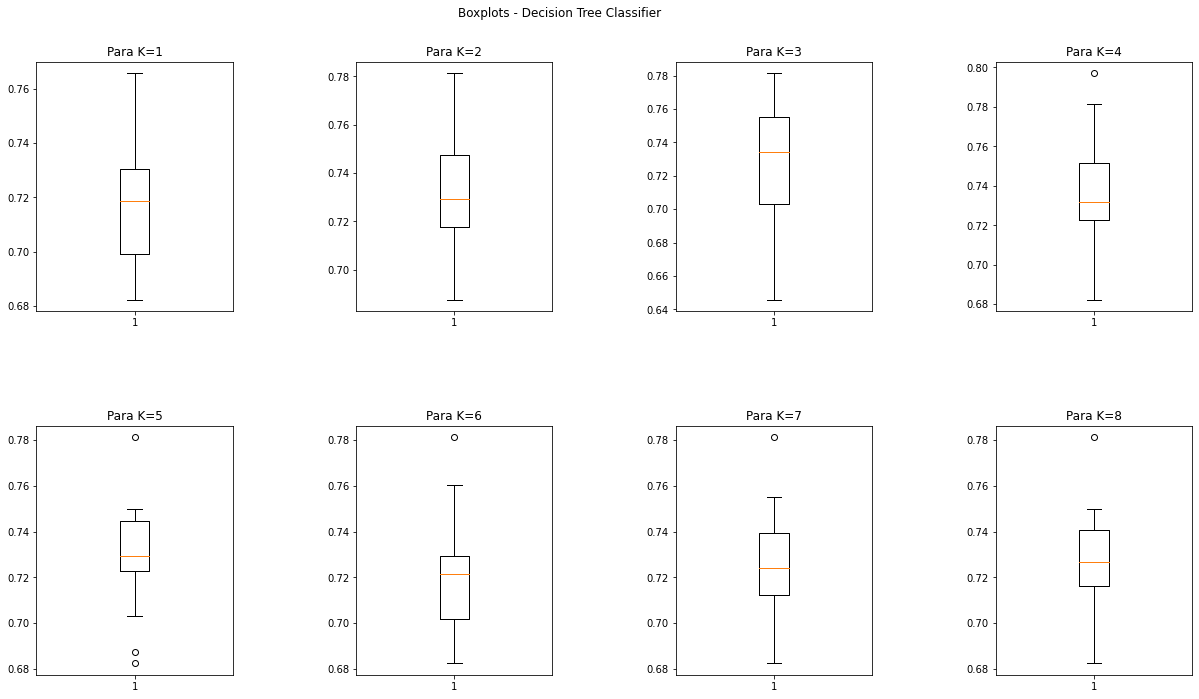

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 4)

for k in range(0,8):
  accuracy,kappa = model_evaluation_2(4,4,'d_tree',x,y,k+1)
  if k<4:
    axs[0, k].boxplot(accuracy)
    axs[0, k].set_title("Para K="+str(k+1))
  else:
    axs[1, k-4].boxplot(accuracy)
    axs[1, k-4].set_title("Para K="+str(k+1))

fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
fig.suptitle('Boxplots - Decision Tree Classifier')

Text(0.5, 0.98, 'Boxplots - Random Forest Classifier')

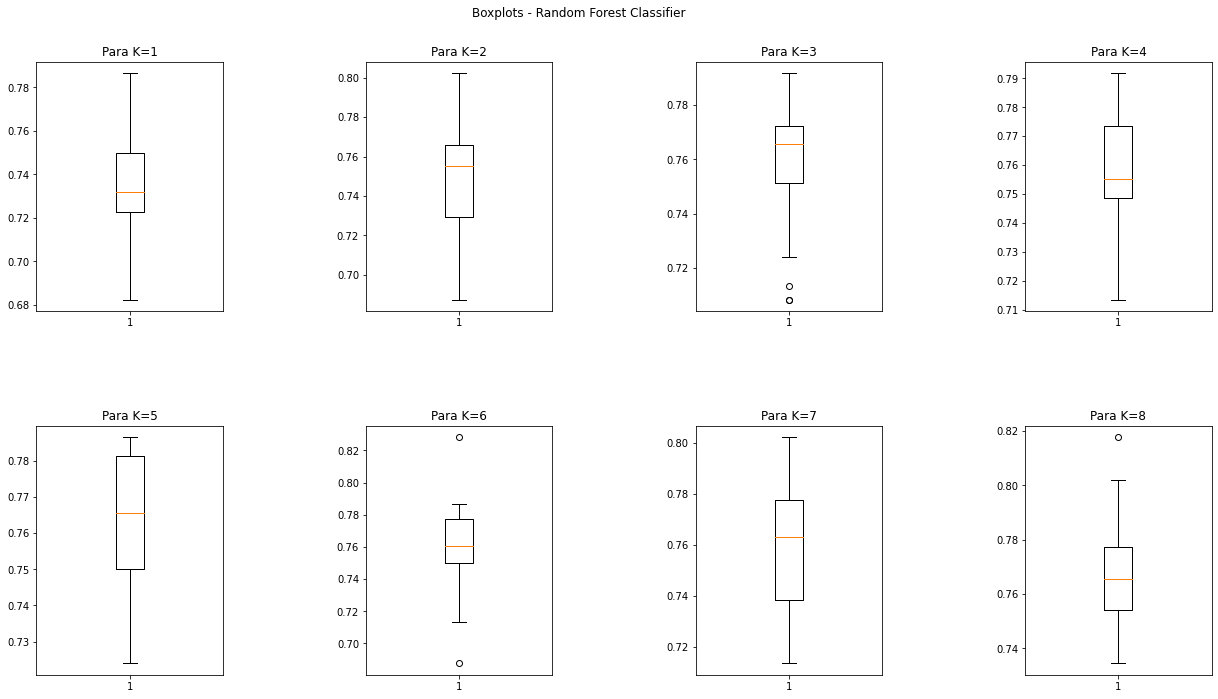

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 4)

for k in range(0,8):
  accuracy,kappa = model_evaluation_2(4,4,'r_forest',x,y,k+1)
  if k<4:
    axs[0, k].boxplot(accuracy)
    axs[0, k].set_title("Para K="+str(k+1))
  else:
    axs[1, k-4].boxplot(accuracy)
    axs[1, k-4].set_title("Para K="+str(k+1))

fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
fig.suptitle('Boxplots - Random Forest Classifier')

Text(0.5, 0.98, 'Boxplots - Support Vector Machine')

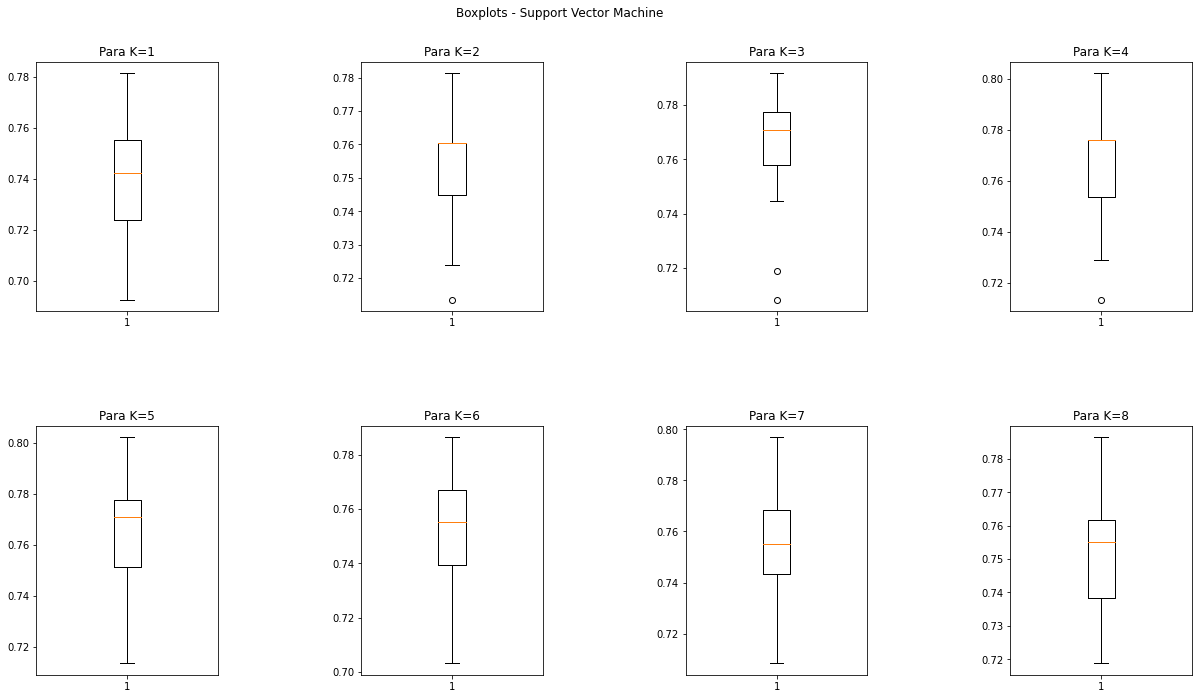

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 4)

for k in range(0,8):
  accuracy,kappa = model_evaluation_2(4,4,'svm',x,y,k+1)
  if k<4:
    axs[0, k].boxplot(accuracy)
    axs[0, k].set_title("Para K="+str(k+1))
  else:
    axs[1, k-4].boxplot(accuracy)
    axs[1, k-4].set_title("Para K="+str(k+1))

fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
fig.suptitle('Boxplots - Support Vector Machine')

Text(0.5, 0.98, 'Boxplots - Gxboost')

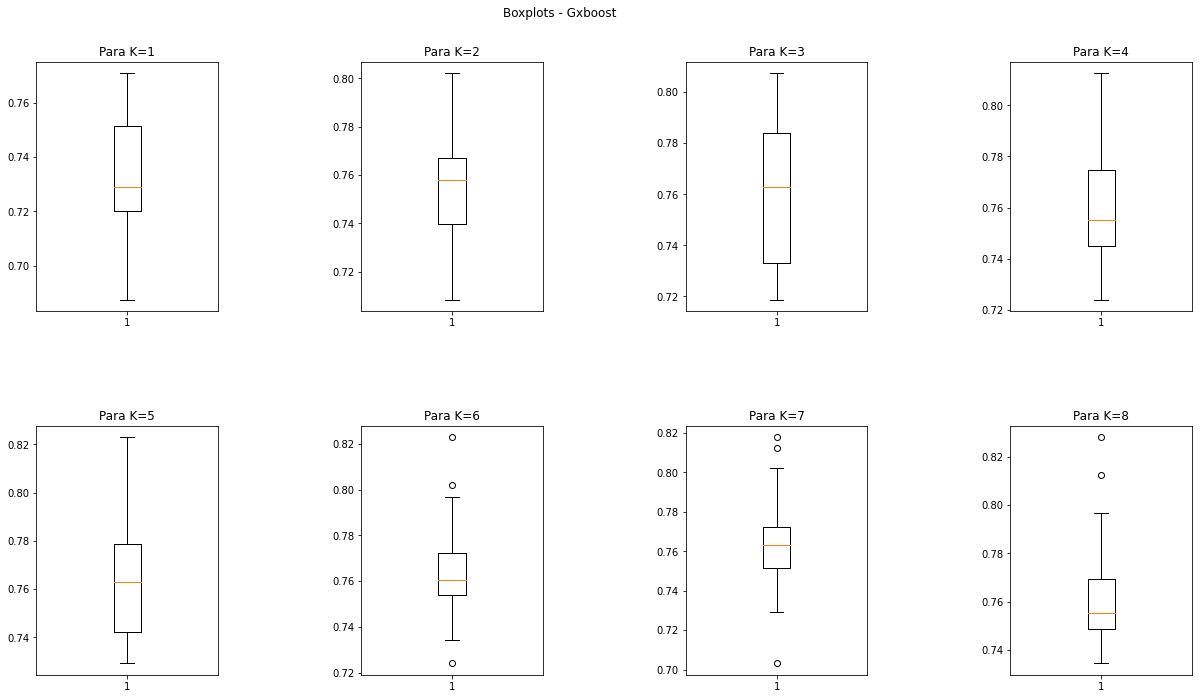

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 4)

for k in range(0,8):
  accuracy,kappa = model_evaluation_2(4,4,'gxboost',x,y,k+1)
  if k<4:
    axs[0, k].boxplot(accuracy)
    axs[0, k].set_title("Para K="+str(k+1))
  else:
    axs[1, k-4].boxplot(accuracy)
    axs[1, k-4].set_title("Para K="+str(k+1))

fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
fig.suptitle('Boxplots - Gxboost')

## Conclusões

1 - 